<span style="font-family: serif;font-size: 28px;">Load the data</span>

In [40]:
import pandas as pd
import numpy as np

df = pd.read_csv("CDC_Diabetes_Dataset_prep.csv")
df = df.drop(columns=["Diabetes_012"])

<span style="font-family: serif;font-size: 28px;">Identifying numerical and categorical data</span>

In [ ]:
for col in df.columns:
    print(col, np.sort(df[col].unique()))

HighBP [0. 1.]
HighChol [0. 1.]
CholCheck [0. 1.]
BMI [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.
 84. 85. 86. 87. 88. 89. 90. 91. 92. 95. 96. 98.]
Smoker [0. 1.]
Stroke [0. 1.]
HeartDiseaseorAttack [0. 1.]
PhysActivity [0. 1.]
Fruits [0. 1.]
Veggies [0. 1.]
HvyAlcoholConsump [0. 1.]
AnyHealthcare [0. 1.]
NoDocbcCost [0. 1.]
GenHlth [1. 2. 3. 4. 5.]
MentHlth [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
PhysHlth [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
DiffWalk [0. 1.]
Sex [0. 1.]
Age [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
Education [1. 2. 3. 4. 5. 6.]
Income [1. 

In [42]:
numerical_cols = [
    'BMI',
    'MentHlth',
    'PhysHlth'
]

binary_cols = [
    'HighBP',
    'HighChol',
    'CholCheck',
    'Smoker',
    'Stroke',
    'HeartDiseaseorAttack',
    'PhysActivity',
    'Fruits',
    'Veggies',
    'HvyAlcoholConsump',
    'AnyHealthcare',
    'NoDocbcCost',
    'DiffWalk',
    'Sex'
]

ordinal_cols = [
    'Age',
    'Education',
    'Income',
    'GenHlth'
]

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [44]:
# Get all column names in order
all_cols = df_scaled.columns.tolist()

# Find indices of categorical columns (binary + ordinal)
categorical_features = binary_cols + ordinal_cols
categorical_indices = [all_cols.index(col) for col in categorical_features]

print("Categorical indices:", categorical_indices)
print("Total categorical features:", len(categorical_indices))  # Should be 18

Categorical indices: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 19, 20, 13]
Total categorical features: 18


In [45]:
X = df_scaled.values

k=2, cost=1116309.406820151
k=3, cost=1004211.2678436562
k=4, cost=896422.7458700517
k=5, cost=843167.6180218582
k=6, cost=814819.2466008755
k=7, cost=784111.4668521594


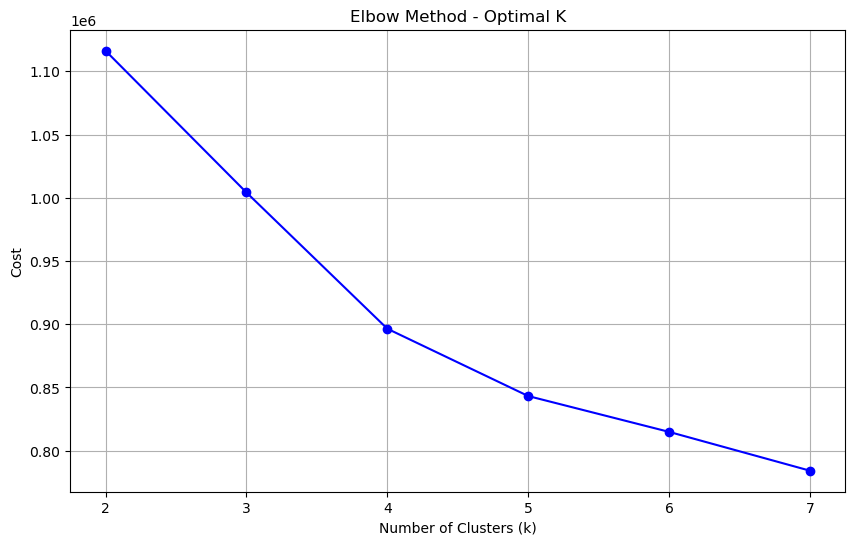

In [46]:
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt

# Test different k values
cost = []
K_range = range(2, 8)  # Try k from 2 to 10

for k in K_range:
    kproto = KPrototypes(n_clusters=k, init='Huang', n_init=5, random_state=42)
    kproto.fit_predict(X, categorical=categorical_indices)
    cost.append(kproto.cost_)
    print(f"k={k}, cost={kproto.cost_}")

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, cost, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method - Optimal K')
plt.grid(True)
plt.show()

In [49]:
X.shape

(227908, 21)

In [50]:
# After selecting optimal k (e.g., k=4), tune gamma
gamma_values = [0.1, 0.5, 1, 2, 5]
costs = []

for gamma in gamma_values:
    kproto = KPrototypes(n_clusters=4, init='Huang', gamma=gamma, random_state=42)
    kproto.fit_predict(X, categorical=categorical_indices)
    costs.append(kproto.cost_)
    print(f"gamma={gamma}, cost={kproto.cost_}")

# Select gamma with lowest cost
best_gamma = gamma_values[np.argmin(costs)]
print(f"\nBest gamma: {best_gamma}")

gamma=0.1, cost=367596.69103454764
gamma=0.5, cost=895932.7914274374
gamma=1, cost=1515189.8428039458
gamma=2, cost=2693372.4070449714
gamma=5, cost=5978230.088499408

Best gamma: 0.1


In [51]:
from kmodes.kprototypes import KPrototypes

# Fit the final model with optimal parameters
kproto = KPrototypes(n_clusters=4, init='Huang', gamma=0.1, 
                     n_init=10, verbose=1, random_state=42)

# Fit and predict clusters
clusters = kproto.fit_predict(df_scaled.values, categorical=categorical_indices)

# Add cluster labels to the dataframe
df_scaled['Cluster'] = clusters
df['Cluster'] = clusters  # Also add to original df

print(f"Clustering complete!")
print(f"Final cost: {kproto.cost_:.2f}")
print(f"\nCluster distribution:")
print(df['Cluster'].value_counts().sort_index())

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 111569, ncost: 454850.5379930714
Run: 1, iteration: 2/100, moves: 35144, ncost: 444299.94278199825
Run: 1, iteration: 3/100, moves: 20887, ncost: 437691.7773841259
Run: 1, iteration: 4/100, moves: 38729, ncost: 385309.76968692086
Run: 1, iteration: 5/100, moves: 16922, ncost: 369180.5419185468
Run: 1, iteration: 6/100, moves: 7603, ncost: 368050.07641914237
Run: 1, iteration: 7/100, moves: 3672, ncost: 367745.47124059824
Run: 1, iteration: 8/100, moves: 2388, ncost: 367640.76516446157
Run: 1, iteration: 9/100, moves: 1093, ncost: 367617.8057513709
Run: 1, iteration: 10/100, moves: 983, ncost: 367597.48932403605
Run: 1, iteration: 11/100, moves: 192, ncost: 367596.7422954193
Run: 1, iteration: 12/100, moves: 23, ncost: 367596.7093501858
Run: 1, iteration: 13/100, moves: 12, ncost: 367596.69103454764
Run: 1, iteration: 14/100, moves: 0, ncost: 367596.69103454764
Init: initiali

In [55]:
# Analyze cluster sizes
cluster_sizes = df['Cluster'].value_counts().sort_index()
print("\n" + "="*50)
print("CLUSTER SIZES")
print("="*50)
for cluster_id, size in cluster_sizes.items():
    percentage = (size / len(df)) * 100
    print(f"Cluster {cluster_id}: {size:,} samples ({percentage:.2f}%)")

# Alternative approach: Calculate centroids manually
print("\n" + "="*50)
print("CLUSTER PROFILES")
print("="*50)

for cluster_id in range(4):
    cluster_data = df[df['Cluster'] == cluster_id]
    cluster_data_scaled = df_scaled[df_scaled['Cluster'] == cluster_id]
    
    print(f"\n{'='*50}")
    print(f"CLUSTER {cluster_id} (n={len(cluster_data):,}, {len(cluster_data)/len(df)*100:.2f}%)")
    print(f"{'='*50}")
    
    # Numerical features (mean of scaled values)
    print("\nNumerical Features (Standardized Mean):")
    for col in numerical_cols:
        mean_val = cluster_data_scaled[col].mean()
        print(f"  {col}: {mean_val:.3f}")
    
    # Numerical features (original scale)
    print("\nNumerical Features (Original Scale - Mean ± Std):")
    for col in numerical_cols:
        mean_val = cluster_data[col].mean()
        std_val = cluster_data[col].std()
        print(f"  {col}: {mean_val:.2f} ± {std_val:.2f}")
    
    # Binary features (percentage)
    print("\nBinary Features (% = 1):")
    for col in binary_cols:
        if col in cluster_data.columns:
            pct = cluster_data[col].mean() * 100
            print(f"  {col}: {pct:.1f}%")
    
    # Ordinal features (mode and mean)
    print("\nOrdinal Features:")
    for col in ordinal_cols:
        mode_val = cluster_data[col].mode()[0] if len(cluster_data[col].mode()) > 0 else 'N/A'
        mean_val = cluster_data[col].mean()
        median_val = cluster_data[col].median()
        print(f"  {col}: Mode={mode_val}, Mean={mean_val:.2f}, Median={median_val:.1f}")


CLUSTER SIZES
Cluster 0: 21,227 samples (9.31%)
Cluster 1: 139,143 samples (61.05%)
Cluster 2: 18,978 samples (8.33%)
Cluster 3: 48,560 samples (21.31%)

CLUSTER PROFILES

CLUSTER 0 (n=21,227, 9.31%)

Numerical Features (Standardized Mean):
  BMI: 0.129
  MentHlth: -0.108
  PhysHlth: 2.363

Numerical Features (Original Scale - Mean ± Std):
  BMI: 29.57 ± 6.72
  MentHlth: 2.70 ± 4.54
  PhysHlth: 26.15 ± 5.81

Binary Features (% = 1):
  HighBP: 62.5%
  HighChol: 56.3%
  CholCheck: 97.9%
  Smoker: 57.8%
  Stroke: 10.8%
  HeartDiseaseorAttack: 22.6%
  PhysActivity: 54.0%
  Fruits: 60.6%
  Veggies: 76.6%
  HvyAlcoholConsump: 3.9%
  AnyHealthcare: 95.5%
  NoDocbcCost: 14.5%
  DiffWalk: 58.4%
  Sex: 41.9%

Ordinal Features:
  Age: Mode=10.0, Mean=9.16, Median=9.0
  Education: Mode=4.0, Mean=4.70, Median=5.0
  Income: Mode=8.0, Mean=4.94, Median=5.0
  GenHlth: Mode=4.0, Mean=3.76, Median=4.0

CLUSTER 1 (n=139,143, 61.05%)

Numerical Features (Standardized Mean):
  BMI: -0.464
  MentHlth: -0.2

In [56]:
df.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Cluster'],
      dtype='object')

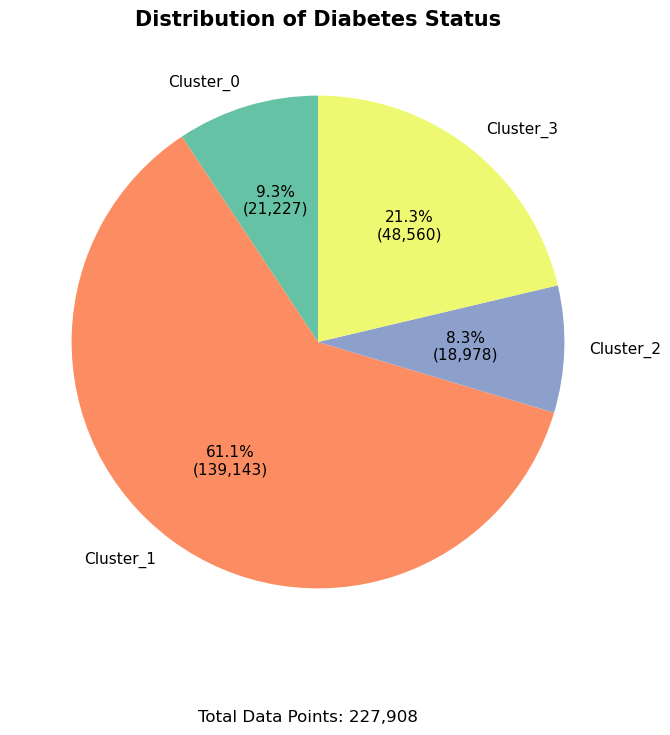

In [58]:
# Count values
counts = df['Cluster'].value_counts().sort_index()

# Label mapping
labels = ['Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3']

# Better colour palette
colors = ['#66c2a5', '#fc8d62', '#8da0cb', "#eef971"]  # teal, orange, soft blue

# Function to show count + percentage
def autopct_format(values):
    def format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count:,})'
    return format

# Total datapoints
total_points = counts.sum()

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(counts,
        labels=labels,
        colors=colors,
        autopct=autopct_format(counts),
        startangle=90,
        textprops={'fontsize': 11})

plt.title("Distribution of Diabetes Status", fontsize=15, weight='bold')

# Add total datapoints at bottom
plt.figtext(0.5, 0.02,
            f"Total Data Points: {total_points:,}",
            ha="center",
            fontsize=12)

plt.show()


In [61]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

# Correct evaluation approach
print("="*50)
print("PROPER CLUSTERING EVALUATION")
print("="*50)

# 1. K-Prototypes native metric
print(f"\n1. Total Cost (K-Prototypes): {kproto.cost_:.2f}")

# 2. Silhouette on numerical features only
X_numerical = df_scaled[numerical_cols].values
sil_numerical = silhouette_score(X_numerical, clusters, metric='euclidean')
print(f"2. Silhouette (Numerical features only): {sil_numerical:.4f}")

# 3. External validation with diabetes labels
df_original = pd.read_csv("CDC_Diabetes_Dataset_prep.csv")
homogeneity = homogeneity_score(df_original['Diabetes_012'], clusters)
completeness = completeness_score(df_original['Diabetes_012'], clusters)
v_measure = v_measure_score(df_original['Diabetes_012'], clusters)
print(f"3. Homogeneity Score: {homogeneity:.4f}")
print(f"4. Completeness Score: {completeness:.4f}")
print(f"5. V-Measure Score: {v_measure:.4f}")

# 4. Clinical interpretation
print("\n6. Cluster-Diabetes Cross-tabulation (Row %):")
crosstab_pct = pd.crosstab(clusters, df_original['Diabetes_012'], normalize='index')
print(crosstab_pct.round(3))

print("\n7. Cluster-Diabetes Cross-tabulation (Counts):")
crosstab_counts = pd.crosstab(clusters, df_original['Diabetes_012'])
print(crosstab_counts)

# 5. Chi-square test
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(crosstab_counts)
print(f"\n8. Chi-square test for independence:")
print(f"   χ² = {chi2:.2f}, p-value = {p_value:.4e}")
if p_value < 0.05:
    print("   → Clusters are significantly associated with diabetes status")
else:
    print("   → No significant association found")

PROPER CLUSTERING EVALUATION

1. Total Cost (K-Prototypes): 367596.69
2. Silhouette (Numerical features only): 0.4588
3. Homogeneity Score: 0.0413
4. Completeness Score: 0.0205
5. V-Measure Score: 0.0274

6. Cluster-Diabetes Cross-tabulation (Row %):
Diabetes_012    0.0    1.0    2.0
row_0                            
0             0.698  0.026  0.276
1             0.889  0.016  0.096
2             0.749  0.029  0.223
3             0.732  0.028  0.240

7. Cluster-Diabetes Cross-tabulation (Counts):
Diabetes_012     0.0   1.0    2.0
row_0                            
0              14806   556   5865
1             123673  2164  13306
2              14210   543   4225
3              35562  1366  11632

8. Chi-square test for independence:
   χ² = 10187.42, p-value = 0.0000e+00
   → Clusters are significantly associated with diabetes status


In [62]:
# Let's understand WHAT makes these clusters different
df_original['Cluster'] = clusters

print("\n" + "="*70)
print("DETAILED CLUSTER PROFILES")
print("="*70)

for cluster_id in range(4):
    cluster_data = df_original[df_original['Cluster'] == cluster_id]
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id} (n={len(cluster_data):,}, {len(cluster_data)/len(df_original)*100:.1f}%)")
    print(f"{'='*70}")
    
    # Diabetes distribution
    diabetes_dist = cluster_data['Diabetes_012'].value_counts(normalize=True) * 100
    print(f"\nDiabetes Distribution:")
    print(f"  No Diabetes:  {diabetes_dist.get(0.0, 0):.1f}%")
    print(f"  Prediabetes:  {diabetes_dist.get(1.0, 0):.1f}%")
    print(f"  Diabetes:     {diabetes_dist.get(2.0, 0):.1f}%")
    
    # Numerical features
    print(f"\nNumerical Features (Mean):")
    for col in numerical_cols:
        mean_val = cluster_data[col].mean()
        overall_mean = df_original[col].mean()
        diff = ((mean_val - overall_mean) / overall_mean) * 100
        print(f"  {col:12s}: {mean_val:6.2f} (overall: {overall_mean:6.2f}, diff: {diff:+5.1f}%)")
    
    # Key binary features
    print(f"\nKey Binary Features (% Yes):")
    key_binary = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
                  'PhysActivity', 'DiffWalk']
    for col in key_binary:
        pct = cluster_data[col].mean() * 100
        overall_pct = df_original[col].mean() * 100
        print(f"  {col:20s}: {pct:5.1f}% (overall: {overall_pct:5.1f}%)")
    
    # Ordinal features
    print(f"\nOrdinal Features (Mean):")
    for col in ordinal_cols:
        mean_val = cluster_data[col].mean()
        overall_mean = df_original[col].mean()
        print(f"  {col:12s}: {mean_val:5.2f} (overall: {overall_mean:5.2f})")


DETAILED CLUSTER PROFILES

CLUSTER 0 (n=21,227, 9.3%)

Diabetes Distribution:
  No Diabetes:  69.8%
  Prediabetes:  2.6%
  Diabetes:     27.6%

Numerical Features (Mean):
  BMI         :  29.57 (overall:  28.69, diff:  +3.1%)
  MentHlth    :   2.70 (overall:   3.53, diff: -23.6%)
  PhysHlth    :  26.15 (overall:   4.71, diff: +455.0%)

Key Binary Features (% Yes):
  HighBP              :  62.5% (overall:  45.3%)
  HighChol            :  56.3% (overall:  44.1%)
  Smoker              :  57.8% (overall:  46.6%)
  Stroke              :  10.8% (overall:   4.5%)
  HeartDiseaseorAttack:  22.6% (overall:  10.4%)
  PhysActivity        :  54.0% (overall:  73.2%)
  DiffWalk            :  58.4% (overall:  18.7%)

Ordinal Features (Mean):
  Age         :  9.16 (overall:  8.08)
  Education   :  4.70 (overall:  4.98)
  Income      :  4.94 (overall:  5.88)
  GenHlth     :  3.76 (overall:  2.60)

CLUSTER 1 (n=139,143, 61.1%)

Diabetes Distribution:
  No Diabetes:  88.9%
  Prediabetes:  1.6%
  Diabetes

In [64]:
# Let's create a summary comparison
import matplotlib.pyplot as plt
import seaborn as sns

# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('K-Prototypes Cluster Comparison: Health Risk Profiles', 
             fontsize=16, fontweight='bold', y=1.02)

# Prepare data
cluster_names = ['Cluster 0:\nElderly Disabled', 
                 'Cluster 1:\nHealthy Active',
                 'Cluster 2:\nMental Health Crisis',
                 'Cluster 3:\nObesity-Driven']

colors = ['#e74c3c', '#2ecc71', '#f39c12', '#e67e22']

# 1. Diabetes Distribution
ax = axes[0, 0]
diabetes_rates = [27.6, 9.6, 22.3, 24.0]
bars = ax.bar(range(4), diabetes_rates, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_xticks(range(4))
ax.set_xticklabels(cluster_names, fontsize=9)
ax.set_ylabel('Diabetes Rate (%)', fontsize=11, fontweight='bold')
ax.set_title('Diabetes Prevalence by Cluster', fontsize=12, fontweight='bold')
ax.axhline(y=13.7, color='red', linestyle='--', linewidth=2, label='Overall Average')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(diabetes_rates):
    ax.text(i, v + 1, f'{v}%', ha='center', fontweight='bold', fontsize=10)

# 2. BMI Comparison
ax = axes[0, 1]
bmi_values = [29.57, 25.53, 29.89, 36.89]
bars = ax.bar(range(4), bmi_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_xticks(range(4))
ax.set_xticklabels(cluster_names, fontsize=9)
ax.set_ylabel('BMI', fontsize=11, fontweight='bold')
ax.set_title('Average BMI by Cluster', fontsize=12, fontweight='bold')
ax.axhline(y=28.69, color='blue', linestyle='--', linewidth=2, label='Overall Average')
ax.axhline(y=25, color='green', linestyle=':', linewidth=1.5, label='Normal/Overweight Cutoff')
ax.axhline(y=30, color='orange', linestyle=':', linewidth=1.5, label='Obesity Cutoff')
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(bmi_values):
    ax.text(i, v + 0.5, f'{v:.1f}', ha='center', fontweight='bold', fontsize=10)

# 3. Physical Health Problems
ax = axes[0, 2]
physhlth_values = [26.15, 1.18, 14.02, 1.83]
bars = ax.bar(range(4), physhlth_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_xticks(range(4))
ax.set_xticklabels(cluster_names, fontsize=9)
ax.set_ylabel('Days per Month', fontsize=11, fontweight='bold')
ax.set_title('Physical Health Problems (Days/Month)', fontsize=12, fontweight='bold')
ax.axhline(y=4.71, color='blue', linestyle='--', linewidth=2, label='Overall Average')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(physhlth_values):
    ax.text(i, v + 1, f'{v:.1f}', ha='center', fontweight='bold', fontsize=10)

# 4. Mental Health Problems
ax = axes[1, 0]
menthlth_values = [2.70, 1.23, 26.58, 1.50]
bars = ax.bar(range(4), menthlth_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_xticks(range(4))
ax.set_xticklabels(cluster_names, fontsize=9)
ax.set_ylabel('Days per Month', fontsize=11, fontweight='bold')
ax.set_title('Mental Health Problems (Days/Month)', fontsize=12, fontweight='bold')
ax.axhline(y=3.53, color='blue', linestyle='--', linewidth=2, label='Overall Average')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(menthlth_values):
    ax.text(i, v + 1, f'{v:.1f}', ha='center', fontweight='bold', fontsize=10)

# 5. Key Risk Factors Heatmap Data
ax = axes[1, 1]
risk_data = np.array([
    [62.5, 56.3, 10.8, 58.4, 54.0],  # Cluster 0
    [37.0, 39.9, 3.3, 8.7, 79.5],     # Cluster 1
    [53.5, 53.1, 8.6, 44.5, 58.3],    # Cluster 2
    [58.4, 47.3, 3.6, 20.0, 69.0]     # Cluster 3
])
risk_labels = ['HighBP', 'HighChol', 'Stroke', 'DiffWalk', 'PhysActivity']
sns.heatmap(risk_data, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            xticklabels=risk_labels, yticklabels=cluster_names,
            cbar_kws={'label': '% or Rate'}, ax=ax, linewidths=1, linecolor='black')
ax.set_title('Key Health Risk Factors (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('')

# 6. Cluster Size Distribution
ax = axes[1, 2]
sizes = [9.3, 61.1, 8.3, 21.3]
bars = ax.bar(range(4), sizes, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_xticks(range(4))
ax.set_xticklabels(cluster_names, fontsize=9)
ax.set_ylabel('Percentage of Total (%)', fontsize=11, fontweight='bold')
ax.set_title('Cluster Size Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, v in enumerate(sizes):
    ax.text(i, v + 1, f'{v}%', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('cluster_analysis_comprehensive.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

print("Comprehensive cluster analysis visualization created!")

Comprehensive cluster analysis visualization created!


In [66]:
df.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'Cluster'],
      dtype='object')

In [ ]:
df.to_csv("kprototype_algorithm_result.csv")